# Melodia: A Python Library for Protein Structure and Dynamics Analysis

## Structure Similarity Analysis

In [1]:
import warnings

import dill

import pandas as pd
import melodia as mel
import seaborn as sns
import matplotlib.pyplot as plt

from os import path
from math import sqrt
from sklearn import cluster
from sklearn.cluster import Birch
from sklearn.preprocessing import StandardScaler
from Bio.PDB.PDBExceptions import PDBConstructionWarning

In [2]:
warnings.filterwarnings("ignore", category=PDBConstructionWarning)

### Melodia can parser an alignment in the PIR file format

In [3]:
# Dill can be used for storage
if path.exists('model.dill'):
    with open('model.dill', 'rb') as file:
        align = dill.load(file)
else:
    align = mel.parser_pir_file('model.ali')
    with open('model.dill', 'wb') as file:
        dill.dump(align, file)

In [4]:
df = mel.dataframe_from_alignment(align=align, keys=['curvature', 'torsion'])

In [5]:
df.head()

,seq_1cdoa,curvature_1cdoa,torsion_1cdoa,seq_1d1ta,curvature_1d1ta,torsion_1d1ta,seq_1teha,curvature_1teha,torsion_1teha,seq_2ohxa,curvature_2ohxa,torsion_2ohxa,seq_3huda,curvature_3huda,torsion_3huda
0,A,0.911238,0.110831,G,1.047306,0.110002,-,0.000000,0.000000,S,0.858952,0.103759,S,0.794220,0.107699
1,T,0.911238,0.110831,T,1.047306,0.110002,-,0.000000,0.000000,T,0.858952,0.103759,T,0.794220,0.107699
2,V,0.434979,0.044909,A,0.454057,0.032614,A,0.644497,0.121356,A,0.505272,0.043087,A,0.463674,0.074985
3,G,0.822893,0.062217,G,0.801947,0.048148,N,0.644497,0.121356,G,0.697603,0.059488,G,0.572861,0.099983
4,K,0.390131,-0.000838,K,0.504131,-0.012812,E,0.535522,-0.003564,K,0.366238,-0.007581,K,0.347366,0.004505


In [6]:
ids = [record.description.split(':')[1] for record in align if 'structure' in record.description]
ids

['1cdoa', '1d1ta', '1teha', '2ohxa', '3huda']

In [7]:
features = []
for id in ids:
    features.append(f'curvature_{id}')
    features.append( f'torsion_{id}')

features

['curvature_1cdoa',
 'torsion_1cdoa',
 'curvature_1d1ta',
 'torsion_1d1ta',
 'curvature_1teha',
 'torsion_1teha',
 'curvature_2ohxa',
 'torsion_2ohxa',
 'curvature_3huda',
 'torsion_3huda']

In [8]:
dfa = df.copy()

autoscaler = StandardScaler()

dfa[features] = autoscaler.fit_transform(dfa[features])

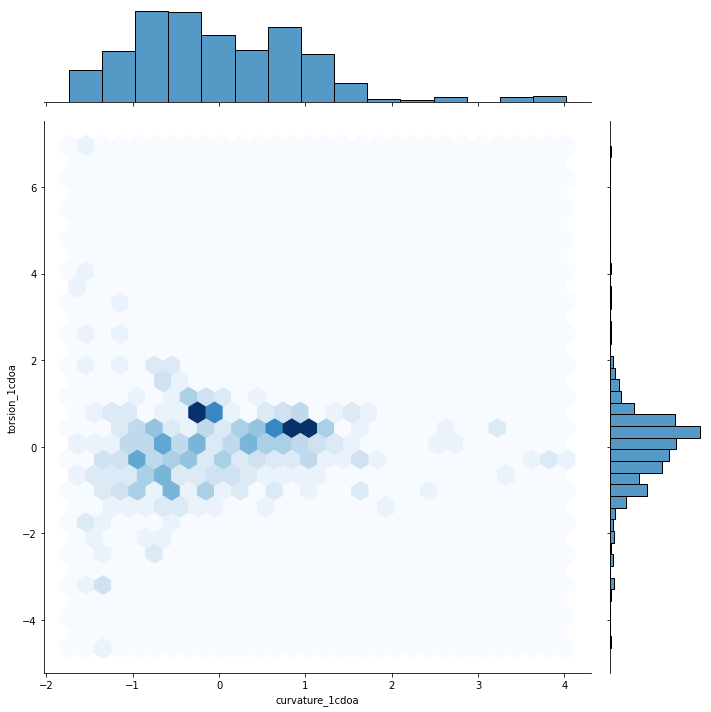

In [9]:
cmap = sns.color_palette("Blues", as_cmap=True)
sns.jointplot(x=features[0], y=features[1], data=dfa, kind='hex', cmap=cmap, height=10)
plt.show();

In [10]:
tags = ids.copy()
base = tags.pop()
base

'3huda'

In [11]:
def dist(row):
    d = (row[f'curvature_{base}'] - row[f'curvature_{cmp}'])**2 + (row[f'torsion_{base}'] - row[f'torsion_{cmp}'])**2
    return sqrt(d)

columns = []
for cmp in tags:    
    dfa[f'{base}_{cmp}'] = dfa.apply(dist, axis=1)
    columns.append(f'{base}_{cmp}')

columns

['3huda_1cdoa', '3huda_1d1ta', '3huda_1teha', '3huda_2ohxa']

In [13]:
dfa.head()

,seq_1cdoa,curvature_1cdoa,torsion_1cdoa,seq_1d1ta,curvature_1d1ta,torsion_1d1ta,seq_1teha,curvature_1teha,torsion_1teha,seq_2ohxa,curvature_2ohxa,torsion_2ohxa,seq_3huda,curvature_3huda,torsion_3huda,3huda_1cdoa,3huda_1d1ta,3huda_1teha,3huda_2ohxa
0,A,3.281796,0.285787,G,4.101160,0.317997,-,-1.783108,-0.038122,S,3.140719,0.298150,S,2.904385,0.345216,0.382061,1.197084,4.703142,0.240975
1,T,3.281796,0.285787,T,4.101160,0.317997,-,-1.783108,-0.038122,T,3.140719,0.298150,T,2.904385,0.345216,0.382061,1.197084,4.703142,0.240975
2,V,0.656423,0.100089,A,0.770838,0.098941,A,1.818038,0.340363,A,1.099661,0.128749,A,0.919324,0.251685,0.303477,0.213023,0.903078,0.218253
3,G,2.794792,0.148844,G,2.723790,0.142911,N,1.818038,0.340363,G,2.209590,0.174541,G,1.575036,0.323156,1.232148,1.162809,0.243610,0.651725
4,K,0.409196,-0.028777,K,1.051942,-0.029642,E,1.209138,-0.049237,K,0.297306,-0.012722,K,0.220843,0.050178,0.204232,0.834923,0.993282,0.099011


In [14]:
column = columns[0]
df_clust = dfa[column].copy().reset_index()
df_clust.head()

,index,3huda_1cdoa
0,0,0.382061
1,1,0.382061
2,2,0.303477
3,3,1.232148
4,4,0.204232


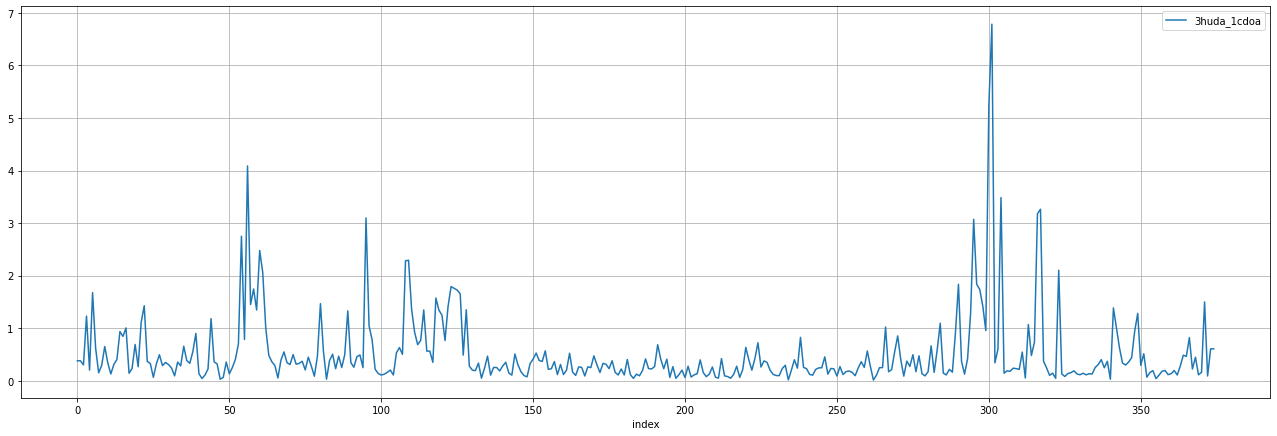

In [15]:
df_clust.plot(x='index', y=column, figsize=(6.4*3.5, 4.8*1.5))
plt.grid();

In [16]:
threshold = 1.0

labels = [0 if x > threshold else 1 for x in list(df_clust[column])]

similar = [i for i, label in enumerate(labels) if label > 0]

j = 0
new = True
regions = {0:[]}
for i in range(len(similar)-1):
    curr_value = similar[i]
    next_value = similar[i+1]
    if next_value - curr_value == 1:
        if new:
            j += 1
            new = False
            regions[j] = [curr_value]
            regions[j].append(next_value)
        else:
            regions[j].append(next_value)
    else:
        regions[0].append(curr_value)
        new = True

In [17]:
clabels = labels.copy()

min_length = 3

i = 0
for key, values in regions.items():
    min_value = min(values)
    max_value = max(values)
    length = max_value - min_value + 1
    if length >= min_length and key > 0:
        i += 1
        print(f'region {key:2d} -> {i:2d}: {min_value:03d}-{max_value:03d}  length: {length:2d}')
        for j in values:
            clabels[j] = i
    else:
        if key > 0:
            print(f'region {key:2d} ->  0: {min_value:03d}-{max_value:03d}  length: {length:2d}')
        
        for j in values:
            clabels[j] = 0


region  1 ->  1: 000-002  length:  3
region  2 ->  2: 006-015  length: 10
region  3 ->  3: 017-020  length:  4
region  4 ->  4: 023-043  length: 21
region  5 ->  5: 045-053  length:  9
region  6 ->  6: 063-079  length: 17
region  7 ->  7: 081-088  length:  8
region  8 ->  8: 090-094  length:  5
region  9 ->  9: 097-107  length: 11
region 10 -> 10: 111-113  length:  3
region 11 -> 11: 115-117  length:  3
region 12 -> 12: 129-265  length: 137
region 13 -> 13: 267-283  length: 17
region 14 -> 14: 285-289  length:  5
region 15 -> 15: 291-293  length:  3
region 16 ->  0: 302-303  length:  2
region 17 -> 16: 305-312  length:  8
region 18 ->  0: 314-315  length:  2
region 19 -> 17: 318-322  length:  5
region 20 -> 18: 324-340  length: 17
region 21 -> 19: 343-348  length:  6
region 22 -> 20: 350-370  length: 21
region 23 -> 21: 372-374  length:  3


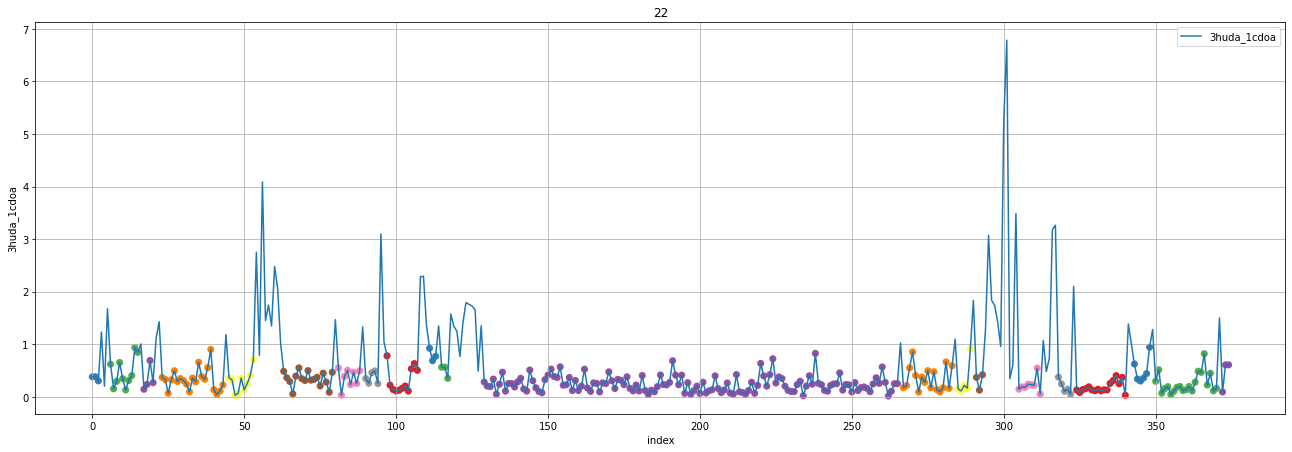

In [18]:
n_clusters = max(clabels)+1

color_palette = sns.color_palette('Set1', n_clusters)
cluster_colors = [color_palette[x] if x > 0 else (1.0, 1.0, 1.0) for x in clabels]

ax = df_clust.plot.scatter(x='index', y=column, s=50, linewidth=0, c=cluster_colors, alpha=1.0, figsize=(6.4*3.5, 4.8*1.5));
df_clust.plot(x='index', y=column, figsize=(6.4*3.5, 4.8*1.5), ax=ax)
plt.title(f'{n_clusters}')
plt.grid()

In [19]:
X = StandardScaler().fit_transform(df_clust)

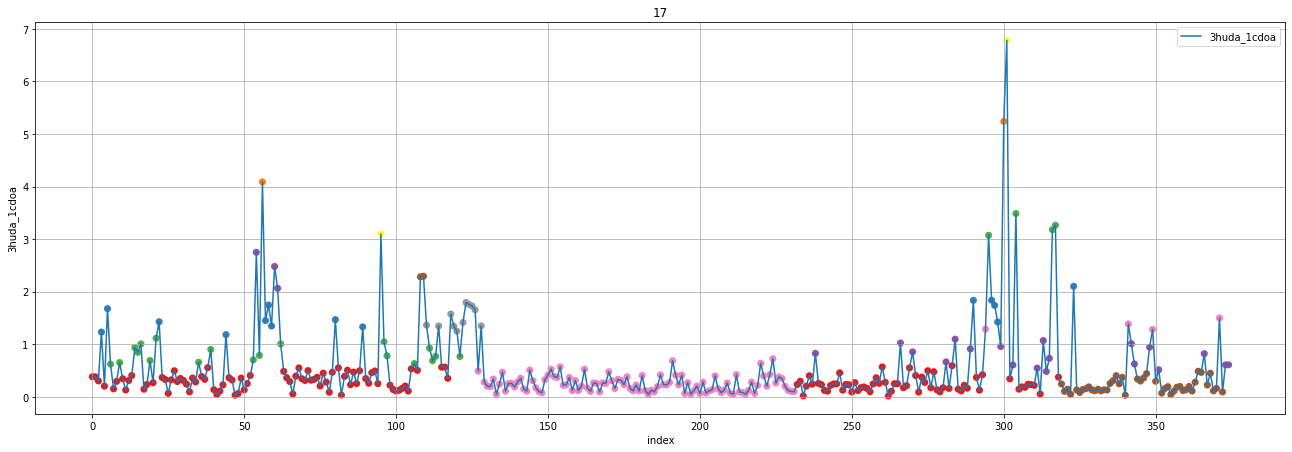

In [23]:
birch_model = cluster.Birch(threshold=0.4, n_clusters=None).fit(X)

n_clusters = max(birch_model.labels_)+1

color_palette = sns.color_palette('Set1', n_clusters)
cluster_colors = [color_palette[x] if x >= 0 else (0.0, 0.5, 0.0) for x in birch_model.labels_]

ax = df_clust.plot.scatter(x='index', y=column, s=50, linewidth=0, c=cluster_colors, alpha=1.0, figsize=(6.4*3.5, 4.8*1.5))
df_clust.plot(x='index', y=column, figsize=(6.4*3.5, 4.8*1.5), ax=ax)
plt.title(f'{n_clusters}')
plt.grid();